In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
import sklearn
from sklearn.metrics import accuracy_score



In [2]:
### Classes: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

In [3]:
## Data Loading and Splitting
data=pd.read_csv("../FaceRecognition.csv")
data=data.drop(columns='Unnamed: 0')
Train_data=data[data['X2306']=='Training'].drop(columns='X2306')
Test_data=data[data['X2306']=='PrivateTest'].drop(columns='X2306')
Train_labels=Train_data.iloc[:,0].values
Test_labels=Test_data.iloc[:,0].values
Train_data=Train_data.drop(columns='X1').values
Test_data=Test_data.drop(columns='X1').values


In [4]:
def vectortoimg(v,show=True):
    plt.imshow(v.reshape(48, 48),interpolation='None', cmap='gray')
    plt.axis('off')
    if show:
        plt.show()

In [30]:
### Applying PCA for Dimension Reduction
def PCA(Training_Data, Testing_Data, threshold):
    meanvector=np.mean(Training_Data,axis=0)
    Z_Train=Training_Data-meanvector
    Z_Test=Testing_Data-meanvector
    C_Train=np.cov(Z_Train.T)  ## Check the shape, should be square matrix with dimensions as number of features : here 2304
    Eigenvalues,Eigenvectors=np.linalg.eigh(C_Train)
    #print('Largest Eigen Value is at Last Index '+str(np.argmax(Eigenvalues)))  ## Largest Eigen Value is at the last index. So, Flipping is required   
    row=Eigenvectors[-1,:];
    col=Eigenvectors[:,-1];
    #print("Row dot product value: Max/Min " + str(max(np.dot(C_Train,row)-(Eigenvalues[-1]*row)))) ## Rows are not eigen vectors
    #print ("Column dot product value: Max/Min"+str(max(np.dot(C_Train,col)-(Eigenvalues[-1]*col))))  #### matrix* EigenVector==EigenValue* EigenVector ,Therefore, Columns are EigenVectors
    ## Columns are Eigen Vectors. Taking Transpose and Inverse
    Eigenvalues=np.flipud(Eigenvalues)
    Eigenvectors=np.flipud(Eigenvectors.T)
    row=Eigenvectors[0,:]
    ## Sanity Checks
    #min(np.dot(C_Train,row)-(Eigenvalues[0]*row))  ## Rows are eigen vectors here 
    #np.allclose(np.dot(C_Train,row),Eigenvalues[0]*row)  ## Check 2  ## We finally got ordered Eigen Vectors and Eigen Values
    prin_comp_train=np.dot(Z_Train,Eigenvectors.T)   ### We always have to find principle components this way for Training Data Set
    prin_comp_test=np.dot(Z_Test, Eigenvectors.T)
    #print('shape of principle_comp_matrix is '+ str(prin_comp.shape))
    cumulative_variance=[]
    temp=0.0
    E_sum=np.sum(Eigenvalues)
    for i in Eigenvalues:
        temp=temp+i
        cumulative_variance.append(temp*100/E_sum)
    pca_num_components=len(list(filter(lambda x: x <= threshold, cumulative_variance))) 
    Train_pca=pd.DataFrame(prin_comp_train[:,:pca_num_components])
    Test_pca=pd.DataFrame(prin_comp_test[:,:pca_num_components])

    
    print('type: numpy.ndarray')
    return Train_pca, Test_pca



In [31]:
Train_pca, Test_pca=PCA(Train_data, Test_data,threshold=75)

type: numpy.ndarray


In [64]:

from scipy.spatial.distance import cdist
def clusters_purity(Train_pca,Train_labels):
    cluster_purity=[]
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(Train_pca)
        kmeanModel.fit(Train_pca)
        kmeanModel.labels=pd.DataFrame(kmeanModel.labels_)
        cm=confusion_matrix(kmeanModel.labels_,Train_labels)
        cluster_purity.append(np.sum(np.amax(cm, axis=0))/sum(sum(cm)))
    return cluster_purity
        
        


In [65]:
cluster_purity=clusters_purity(Train_pca, Train_labels)

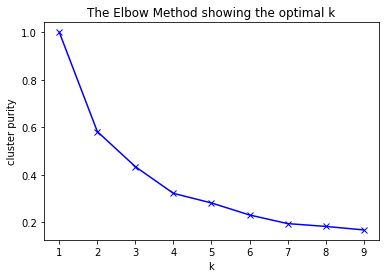

In [67]:
plt.plot(K, cluster_purity, 'bx-')
plt.xlabel('k')
plt.ylabel('cluster purity')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [76]:
Train_pca['labels']=Train_labels
Test_pca['labels']=Test_labels

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [91]:
##### Linear Classifier ##########
### Encoding the Target Labels
#def linear_classifier(Train_pca, Train_labels, Test_pca, Test_labels):
    
Targets_six = np.zeros((Train_pca.shape[0], max(Train_labels)+1))
Targets_six[np.arange(Train_pca.shape[0]), Train_labels] = 1

    ### Preparing augmented matrix
xa_train=Train_pca.iloc[:,:-1]
xa_train.insert(0,column='ones',value=1)
xa_test=Test_pca.iloc[:,:-1]
xa_test.insert(0,column='ones',value=1)

    #### Weights
weights_six=np.dot(np.linalg.pinv(xa_train.values),Targets_six)

    ### Training 
pass_train=np.dot(xa_train,weights_six)
train_passed_labels=[]
for i in range(len(pass_train)):
    train_passed_labels.append(np.argmax(pass_train[i,:]))
train_passed_labels=np.array(train_passed_labels)
    
    ## Testing
pass_test=np.dot(xa_test,weights_six)
test_passed_labels=[]
for i in range(len(pass_test)):
    test_passed_labels.append(np.argmax(pass_test[i,:]))
test_passed_labels=np.array(test_passed_labels)
    

cm_train=confusion_matrix(Train_labels,train_passed_labels,labels=[0,1,2,3,4,5,6])
ppv_table_train=cm_train/np.sum(cm_train,axis=0)
cm_test=confusion_matrix(Test_labels,test_passed_labels,labels=[0,1,2,3,4,5,6])
ppv_table_test=cm_test/np.sum(cm_test,axis=0)
print('-------------------------------------------------------------------------------------')
print('Train_PPV Desc: ' + str(np.sort(ppv_table_train.diagonal())[::-1]))
print('Train_PPV Class Desc: ' + str(np.argsort(ppv_table_train.diagonal())[::-1]))
print('PPV- 7 class classifier: ' + str(1/7) )
print('Accuracy of linear Classifier for Training Set is: ' +str(accuracy_score(Train_labels,train_passed_labels)))
print('-------------------------------------------------------------------------------------')
print('-------------------------------------------------------------------------------------')
print('Test_PPV Desc: ' + str(np.sort(ppv_table_test.diagonal())[::-1]))
print('Test_PPV Class Desc: ' + str(np.argsort(ppv_table_test.diagonal())[::-1]))
print('PPV- 7 class classifier: ' + str(1/7) )
print('Accuracy of linear Classifier for Test Set is: ' +str(accuracy_score(Test_labels,test_passed_labels)))
print('-------------------------------------------------------------------------------------')
    
    



-------------------------------------------------------------------------------------
Train_PPV Desc: [       nan 0.36786469 0.31768334 0.29697525 0.27930239 0.25722543
 0.2311828 ]
Train_PPV Class Desc: [1 5 3 6 4 0 2]
PPV- 7 class classifier: 0.14285714285714285
Accuracy of linear Classifier for Training Set is: 0.3140478595562367
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Test_PPV Desc: [       nan 0.36363636 0.36320755 0.32110529 0.28473804 0.2716763
 0.13207547]
Test_PPV Class Desc: [1 0 5 3 6 4 2]
PPV- 7 class classifier: 0.14285714285714285
Accuracy of linear Classifier for Test Set is: 0.3123432711061577
-------------------------------------------------------------------------------------


C:\Users\Mr.Khiladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Mr.Khiladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


In [92]:
cm_train

array([[  89,    0,   66, 2389,  629,  405,  417],
       [   5,    0,   10,  282,   58,   47,   34],
       [  66,    0,   86, 2334,  566,  629,  416],
       [  36,    0,   53, 5562,  673,  365,  526],
       [  75,    0,   56, 2690, 1089,  305,  615],
       [  32,    0,   55, 1345,  228, 1218,  293],
       [  43,    0,   46, 2906,  656,  342,  972]], dtype=int64)

In [90]:
linear_classifier(Train_pca, Train_labels, Test_pca, Test_labels)

-------------------------------------------------------------------------------------
Train_PPV Desc: [       nan 0.36786469 0.31768334 0.29697525 0.27930239 0.25722543
 0.2311828 ]
Train_PPV Class Desc: [1 5 3 6 4 0 2]
PPV- 7 class classifier: 0.14285714285714285
Accuracy of linear Classifier for Training Set is: 0.3140478595562367
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Test_PPV Desc: [       nan 0.36363636 0.36320755 0.32110529 0.28473804 0.2716763
 0.13207547]
Test_PPV Class Desc: [1 0 5 3 6 4 2]
PPV- 7 class classifier: 0.14285714285714285
Accuracy of linear Classifier for Test Set is: 0.3123432711061577
-------------------------------------------------------------------------------------


C:\Users\Mr.Khiladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Mr.Khiladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [106]:
## Logistic Regression
import sklearn
def log_reg(Train_Data, Train_Labels, Test_Data, Test_Labels):
    class_weight=sklearn.utils.class_weight.compute_class_weight('balanced',np.unique(Train_Labels),Train_Labels)
    class_weight = {key: value for (key, value) in zip(range(6),class_weight)}

#### Model ##########

    logreg = LogisticRegression(C=1e10, solver='newton-cg', multi_class='multinomial',random_state=1234,class_weight=class_weight)
    logreg.fit(Train_Data.iloc[:,:-1], Train_Labels)

### Predict
    log_train_pred=logreg.predict(Train_Data.iloc[:,:-1])
    log_test_pred=logreg.predict(Test_Data.iloc[:,:-1])

## Confusion Matrix
    cm_train=confusion_matrix(Train_Labels,log_train_pred,labels=[0,1,2,3,4,5,6])
    cm_test=confusion_matrix(Test_Labels,log_test_pred,labels=[0,1,2,3,4,5,6])

    #### PPV

    ppv_table_train=cm_train/np.sum(cm_train,axis=0)
    ppv_table_test=cm_test/np.sum(cm_test,axis=0)

    print('-------------------------------------------------------------------------------------')
    print('Train_PPV Desc: ' + str(np.sort(ppv_table_train.diagonal())[::-1]))
    print('Train_PPV Class Desc: ' + str(np.argsort(ppv_table_train.diagonal())[::-1]))
    print('PPV- 7 class classifier: ' + str(1/7) )
    print('Accuracy of logistic regression Classifier for Training Set is: ' +str(accuracy_score(Train_Labels,train_passed_labels)))
    print('-------------------------------------------------------------------------------------')
    print('-------------------------------------------------------------------------------------')
    print('Test_PPV Desc: ' + str(np.sort(ppv_table_test.diagonal())[::-1]))
    print('Test_PPV Class Desc: ' + str(np.argsort(ppv_table_test.diagonal())[::-1]))
    print('PPV- 7 class classifier: ' + str(1/7) )
    print('Accuracy of logistic regression Classifier for Test Set is: ' +str(accuracy_score(Test_Labels,test_passed_labels)))
    print('-------------------------------------------------------------------------------------')
    

In [107]:
log_reg(Train_pca, Train_labels, Test_pca, Test_labels)

-------------------------------------------------------------------------------------
Train_PPV Desc: [0.40295067 0.30001834 0.27471894 0.26188525 0.21105528 0.18690096
 0.03449883]
Train_PPV Class Desc: [3 5 4 6 0 2 1]
PPV- 7 class classifier: 0.14285714285714285
Accuracy of logistic regression Classifier for Training Set is: 0.3140478595562367
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Test_PPV Desc: [0.43809524 0.33233533 0.3015873  0.25503356 0.21449275 0.17419355
 0.03921569]
Test_PPV Class Desc: [3 5 4 6 0 2 1]
PPV- 7 class classifier: 0.14285714285714285
Accuracy of logistic regression Classifier for Test Set is: 0.3123432711061577
-------------------------------------------------------------------------------------


In [108]:
Train_data=pd.DataFrame(Train_data)
Train_data['labels']=Train_labels
Test_data=pd.DataFrame(Test_data)
Test_data['labels']=Test_labels

In [109]:
log_reg(Train_data, Train_labels, Test_data, Test_labels)

C:\Users\Mr.Khiladi\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


-------------------------------------------------------------------------------------
Train_PPV Desc: [0.63283366 0.5        0.45296709 0.44921597 0.43183549 0.43075
 0.29121622]
Train_PPV Class Desc: [3 5 4 6 2 0 1]
PPV- 7 class classifier: 0.14285714285714285
Accuracy of logistic regression Classifier for Training Set is: 0.3140478595562367
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Test_PPV Desc: [0.50678733 0.34839925 0.29268293 0.25296443 0.23368421 0.21588595
 0.07490637]
Test_PPV Class Desc: [3 5 6 4 2 0 1]
PPV- 7 class classifier: 0.14285714285714285
Accuracy of logistic regression Classifier for Test Set is: 0.3123432711061577
-------------------------------------------------------------------------------------


array([[ 70,  80,  82, ..., 106, 109,  82],
       [151, 150, 147, ..., 193, 183, 184],
       [231, 212, 156, ...,  88, 110, 152],
       ...,
       [ 74,  81,  87, ..., 188, 187, 187],
       [222, 227, 203, ..., 136, 136, 134],
       [195, 199, 205, ...,   6,  15,  38]], dtype=int64)